In [1]:
# autoreload imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Initial data exploration

In [2]:
# standard path wrangling to be able to import project config and sources
import os
import sys
root = os.path.dirname(os.getcwd())
sys.path.append(root)

In [3]:
# built-in
import re
import csv
import json
import time
import logging
import datetime
from collections import Counter

# installed
import spacy
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import fasttext

# custom
from src.utils.jupyter_setup import setup_jupyter
from src.data.data_loader import DataLoader
from src.data.path_manager import PathManager

In [4]:
cfg = setup_jupyter(root, logging_level=logging.WARNING)
nlp = spacy.load('en')

Config loaded.
Setup done


## Load data

In [5]:
path_mgr = PathManager(cfg, root)
data_loader = DataLoader(
    user=cfg['index']['user'], password=cfg['index']['password'],
    port=cfg['index']['port'], index_name=cfg['index']['index_name'], 
    hosts=cfg['index']['hosts']
)
data_df = data_loader.load_data(path_mgr.label_map_file)
print('Documents retrieved:', len(data_df))

Documents retrieved: 16797


Remove columns with cruise information

In [6]:
remove_columns = [
    'portName', 'portNation', 'mainMap', 'coordinates', 'content', 'link', 'shipName', 'year built',
    'flag state', 'builder', 'class', 'building cost', 'owner', 'operator', 'speed', 'length (LOA)',
    'beam (width)', 'gross Tonnage', 'passengers', 'crew', 'passengers-to-space ratio', 'decks',
    'cabins', 'decks with cabins', 'last Refurbishment', 'itenerary', 'sister-ships', 'former names',
    'christened by', 'ferry route / homeports', 'cars', 'beds'
]
keep_columns = [col for col in data_df.columns if col not in remove_columns]
data_df = data_df[keep_columns]

Remove empty entries

In [7]:
print(f'Total claims: {len(data_df)}')
data_df.dropna(axis=0, subset=['url', 'fact_original', 'subject'], inplace=True)
print(f'After removing empty rows: {len(data_df)}')

Total claims: 16797
After removing empty rows: 14304


Example entries

In [8]:
data_df.head(2).transpose()

,e99bb3b365b59a1483416853bf9e6a0a,f7f72dcfbc016d292645dd4d088db430
pscreated,1611125697662,1611125697662
author,None,None
dataSource,poynter,poynter
date,2020-10-14 00:00:00,2020-10-12 00:00:00
explanation,None,None
fact,false,false
fact_original,FALSE,FALSE
factCheckedBy,Maldita.es,Maldita.es
keywords,None,None
location,Spain,Spain


Number of claims collected from each fact checker

In [9]:
data_df['dataSource'].value_counts()

poynter         10748
euvsdisinfo      1397
AosFatos         1079
politifact        714
AFP News          332
Vishvas News       34
Name: dataSource, dtype: int64

Total number of claims before cleaning

In [10]:
len(data_df)

14304

In [11]:
# uncomment to print label mapping
# data_df['fact_original'] = data_df['fact_original'].str.lower()
# data_df.groupby(by=['dataSource', 'fact_original'])['fact_new'].apply(set)

Remove EU vs. disinfo claims

In [12]:
selector = data_df['dataSource'] != 'euvsdisinfo'
# data_df.loc[selector, 'subject'] = data_df[selector]['subject'].str.replace('DISINFO:', '').str.strip()
data_df = data_df[selector]

## Clean data

### Clean by source

Remove data from and YouTube, Instagram

In [13]:
# List all sources with at least 10 claims
data_df.source = data_df.source.str.lower()
data_df.author = data_df.author.str.lower()
sources_counts = data_df.source.value_counts()
authors_counts = data_df.author.value_counts()
top_sources = set(sources_counts[sources_counts >= 1].index)
top_authors = set(authors_counts[authors_counts >= 1].index)

# Remove sources that mention specific keywords
filter_keywords = re.compile(r'youtube|instagram|image|photo|video|meme')  
keep_sources = [s for s in top_sources if not re.search(filter_keywords, s)]
keep_authors = [a for a in top_authors if not re.search(filter_keywords, a)]

# Additionally filter subject and summary
subject_filter = np.array([re.search(filter_keywords, s.lower()) is None for s in data_df.subject])
summary_filter = np.array([s is None or re.search(filter_keywords, s.lower()) is None for s in data_df.summary])

# Filter DataFrame by source
data_df = data_df[subject_filter & summary_filter]
data_df = data_df[data_df.source.isin(keep_sources) | data_df.source.isna()]
data_df = data_df[data_df.author.isin(keep_authors) | data_df.author.isna()]
data_df = data_df[data_df.author.notna() | data_df.source.notna()]
print(f'Claims after filtering by source: {len(data_df)}')

Claims after filtering by source: 8884


### Clean by topic

In [14]:
keywords = [
    'chinese', 'corona', 'covid', 'face shield', 'sanitize', 'health work', 'herd immunity', 
    'homeschool', 'kungflu', 'lockdown', 'mask', 'n95', 'ncov', 'pandemic', 'pneumonia', 
    'ppe', 'quarantine', 'sars', 'cov2', 'isolati', 'social distanc', 'vaccine', 'wuhan', 'virus', 
    'chloroquine', 'antigen', 'pfizer', 'moderna', 'death', 'disease', 'stimulus', 'outbreak', 'epidemic', 
    'pcr', 'intensive care', 'curfew', 'respirator', 'case count', 'positive case', 'positive test', 'reopen',
    'close down', 'closing down', 'ventilator'
]
# print(''.join([f'\item {k}\n' for k in sorted(keywords)]))

In [15]:
filter_keywords = re.compile('|'.join(keywords))
subject_filter = np.array([re.search(filter_keywords, s.lower()) is not None for s in data_df.subject])
summary_filter = np.array([s is None or re.search(filter_keywords, s.lower()) is not None for s in data_df.summary])
data_df = data_df[subject_filter | summary_filter]
print(f'Claims after filtering by subject: {len(data_df)}')

Claims after filtering by subject: 7274


### Clean by language

In [16]:
language_filter = []
languages = []
model = fasttext.load_model('../models/fasttext/lid.176.bin')
for s in tqdm(data_df.subject):
    lang = model.predict(s, k=1)[0][0]
    languages.append(lang)
    language_filter.append(lang == '__label__en')
data_df = data_df[language_filter]
print(f'Claims after filtering by language: {len(data_df)}')

  0%|          | 0/7274 [00:00<?, ?it/s]

Claims after filtering by language: 7074


Language statistics

In [17]:
Counter(languages).most_common()

[('__label__en', 7074),
 ('__label__pt', 191),
 ('__label__it', 3),
 ('__label__ja', 2),
 ('__label__fr', 2),
 ('__label__de', 1),
 ('__label__es', 1)]

### Clean by label in subject

In [18]:
keywords = ['disinfo', 'hoax', 'false', 'true', 'mislead', 'fake']
filter_keywords = re.compile('|'.join(keywords))
subject_filter = np.array([re.search(filter_keywords, s.lower()) is None for s in data_df.subject])
data_df = data_df[subject_filter]
print(f'Claims after filtering by label keyword: {len(data_df)}')

Claims after filtering by label keyword: 6972


## Store cleaned data

In [19]:
data_df.to_csv(path_mgr.processed_file_path('fc_cleaned.csv'))

## Basic data statistics

In [20]:
print(f'Final number of claims: {len(data_df)}')
data_df['fact_new'].value_counts()

Final number of claims: 6972


false/misleading    6673
no evidence          177
true                  87
other                 35
Name: fact_new, dtype: int64

Claims by fact checker

In [21]:
data_df['dataSource'].value_counts()

poynter         6483
politifact       467
Vishvas News      22
Name: dataSource, dtype: int64

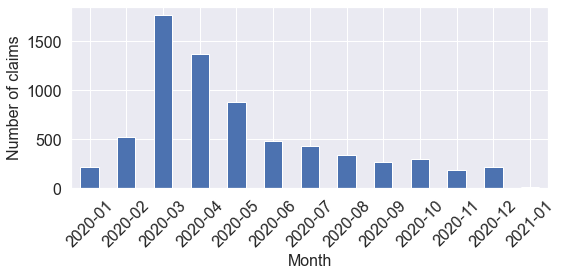

In [22]:
plt.figure(figsize=(8, 4))
data_df['date'].groupby(by=[data_df['date'].dt.year, data_df['date'].dt.month]).count().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of claims')
xticks = []
for x in plt.xticks()[1]:
    tick_text = x._text
    tick_parts = tick_text.strip('()').split(',')
    xticks.append(f'{tick_parts[0]}-{int(tick_parts[1].strip()):02d}')
plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
plt.tight_layout()
plt.savefig(path_mgr.figure_path('claim_age_distribution.pdf'))
plt.show()

Number of claims with location information: 6505


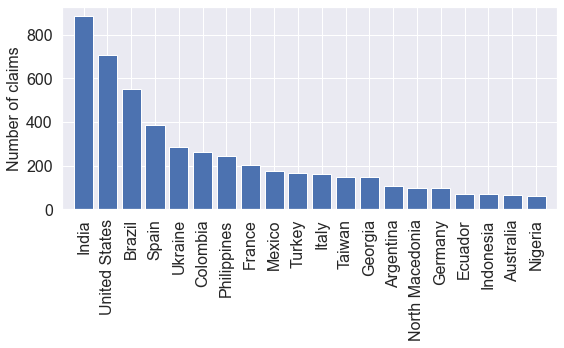

In [23]:
print(f'Number of claims with location information: {len(data_df[data_df["location"].notna()])}')
plt.figure(figsize=(8, 5))
locations_counts = data_df['location'].value_counts()[:20]
plt.bar(np.arange(len(locations_counts)), locations_counts.values)
plt.xticks(np.arange(len(locations_counts)), locations_counts.index, rotation=90)
xlim = plt.xlim()
plt.xlim((xlim[0] + 0.5, xlim[1] - 0.5))
plt.ylabel('Number of claims')
plt.tight_layout()
plt.savefig(path_mgr.figure_path('claim_loc_distribution.pdf'))
plt.show()

Number of claims with source/author information: 6972


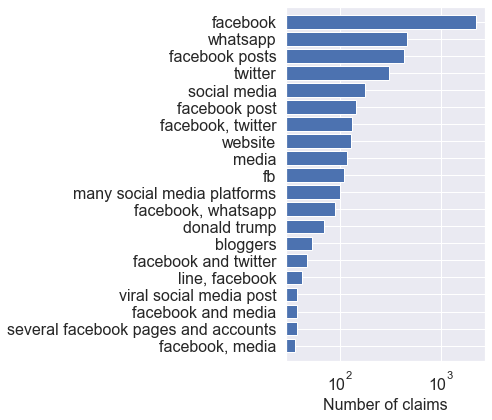

In [24]:
print(
    'Number of claims with source/author information:',
    len(data_df[data_df["source"].notna() | data_df["author"].notna()])
)
plt.figure(figsize=(7, 6))
sources = list(data_df['source']) + list(data_df['author'])
sources, values = zip(*Counter(sources).most_common(21)[1:][::-1])
plt.barh(np.arange(len(sources)), values)
plt.yticks(np.arange(len(sources)), sources)
ylim = plt.ylim()
plt.ylim((ylim[0] + 0.5, ylim[1] - 0.5))
plt.xscale('log')
plt.xlabel('Number of claims')
plt.tight_layout()
plt.savefig(path_mgr.figure_path('claim_source_distribution.pdf'))
plt.show()